In [ ]:
'''This script is a part of Genpact Hackathon'''
   
__author__ = 'Sandeep Kumar Kola'
__email__ = 'sandeep.kola07@gmail.com'

In [55]:
# Import all the required libraries.
import re
import gc
import numpy as np
import pandas as pd
from math import sqrt
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')

In [52]:
class DataPreprocessing():
    """
    Class DataPreprocessing has functions that cleans the data.
    """
    def __init__(self, path_test, path_train, path_center, path_meal):
        self.path_test = path_test
        self.path_train = path_train
        self.path_center = path_center
        self.path_meal = path_meal
    
    def _load_data(path_test, path_train, path_center, path_meal):
        """
        This function loads all the data.
        
        parameters:
        path_test, path_train, path_center, path_meal: File paths.
        
        Returns:
        test, train, center, meal: Dataframes.
        """
        test = pd.read_csv(path_test)
        train = pd.read_csv(path_train)
        center = pd.read_csv(path_center)
        meal = pd.read_csv(path_meal)
        
        return test, train, center, meal
    
    def _merge_data(test, train, center, meal):
        """
        This function merges the data together.
        
        parameters:
        test, train, center, meal: Dataframes.
        
        Returns:
        test, train: Merged Dataframes.
        """
        # Let's add a week number column to make it a seasonal data.
        train['week_number']=train.week%52
        test['week_number']=test.week%52
        
        # We observe that the meal_id, center_id are the foreign keys, let's merge the data.
        # We are using left merge since, we need all the columns from left and the ones from the right.
        # Merging center data.
        train = pd.merge(train,center,how='left',on=['center_id'])
        test = pd.merge(test,center,how='left',on=['center_id'])
        # Merging meal data.
        train = pd.merge(train,meal,how='left',on=['meal_id'])
        test = pd.merge(test,meal,how='left',on=['meal_id'])
        
        return train, test
    
    def _feature_engineering(train, test):
        """
        This function performs feature engineering on the data and creates new features.
        
        parameters:
        train, test: Dataframes.
        
        Returns:
        test, train: Merged Dataframes.
        """
        
        print("-- Creating new features; discount_amount, meal_center_count, cuisine_center_count, \
              meal_count, category_center_count, center_count --") 
        # Create a discounted price feature.
        train['discount_amount'] = train.base_price - train.checkout_price
        test['discount_amount'] = test.base_price - test.checkout_price
        # Group data on meal and count the number of occurences.
        train, test = FeatureEngineering._calculate_count(train, test, cols = ['meal_id'],
                                      column_name = 'meal_count')
        # Group data on center and count the number of occurences.
        train, test = FeatureEngineering._calculate_count(train, test, cols = ['center_id'],
                                      column_name = 'center_count')
        # Group data on meal and center and count the number of occurences of the combination.
        train, test = FeatureEngineering._calculate_count(train, test, cols = ['meal_id','center_id'],
                                      column_name = 'meal_center_count')
        # Group data on cuisine and center and count the number of occurences of the combination.        
        train, test = FeatureEngineering._calculate_count(train, test, cols = ['cuisine','center_id'],
                                      column_name = 'cuisine_center_count')
        # Group data on category and center and count the number of occurences of the combination.
        train, test = FeatureEngineering._calculate_count(train, test, cols = ['category','center_id'],
                                      column_name = 'category_center_count')
        
        print("-- \n Creating new features; meal_center_mean,  center_cuisine_mean, center_category_mean, \
              center_category_cuisine_mean, cuisine_category_mean, center_mean, meal_mean, \
              cuisine_region_mean, city_cuisine_mean, city_region_mean --")
        # Group data on meal and center and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['meal_id','center_id'],
                                      column_name='meal_center_mean')
        # Group data on cuisine and center and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['center_id','cuisine'],
                                      column_name='center_cuisine_mean')
        # Group data on category and center and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['center_id','category'],
                                      column_name='center_category_mean')
        # Group data on cuisine and center and cuisine and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['center_id','category','cuisine'],
                                      column_name='center_category_cuisine_mean')
        # Group data on cuisine and category and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['cuisine','category'],
                                      column_name='cuisine_category_mean')
        # Group data on center and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['center_id'],
                                      column_name='center_mean')
        # Group data on meal and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['meal_id'],
                                      column_name = 'meal_mean')
        # Group data on cuisine and region and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['cuisine','region_code'],
                                      column_name = 'cuisine_region_mean')
        # Group data on category and region and calculate mean of the num_orders of the combination.      
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['category','region_code'],
                                      column_name = 'category_region_mean')
        # Group data on cuisine and city and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['city_code','cuisine'],
                                      column_name = 'city_cuisine_mean')
        # Group data on city and region and calculate mean of the num_orders of the combination.
        train, test = FeatureEngineering._calculate_mean(train, test, cols = ['city_code','region_code'],
                                      column_name = 'city_region_mean')
        
        print("-- Creating new features; meal_center_base_price_mean, meal_center_checkout_price_mean, \
              center_cuisine_base_price_mean, center_cuisine_checkout_price_mean --")   
        # Group data on meal and center and calculate mean of the base_price of the combination.
        train, test = FeatureEngineering._calculate_price_mean(train, test, 
                                                               cols = ['meal_id','center_id'], 
                                                               price_type = 'base_price', 
                                                               column_name = 'meal_center_base_price_mean')
        # Group data on meal and center and calculate mean of the checkout_price of the combination.
        train, test = FeatureEngineering._calculate_price_mean(train, test, 
                                                               cols = ['meal_id','center_id'], 
                                                               price_type = 'checkout_price',
                                                               column_name = 'meal_center_checkout_price_mean')
        # Group data on cuisine and center and calculate mean of the base_price of the combination.
        train, test = FeatureEngineering._calculate_price_mean(train, test, 
                                                               cols = ['center_id','cuisine'], 
                                                               price_type = 'base_price',
                                                               column_name = 'center_cuisine_base_price_mean')
        # Group data on cuisine and center and calculate mean of the checkout_price of the combination.
        train, test = FeatureEngineering._calculate_price_mean(train, test, 
                                                               cols = ['center_id','cuisine'], 
                                                               price_type = 'checkout_price',
                                                               column_name = 'center_cuisine_checkout_price_mean')
        
        return train, test
    
    def _change_datatypes(train, test):
        """
        This function label encodes the object datatypes of the datasets.
        
        parameters:
        train, test: Dataframes.
        
        Returns:
        test, train: Dataframes.
        """
        for col in train.columns :
            if train[col].dtypes == 'object':
                label_encoder = LabelEncoder()
                train[col] = label_encoder.fit_transform(train[col])
                test[col] = label_encoder.transform(test[col])
        return train, test

In [38]:
class FeatureEngineering():
    """
    This class has all the functions to create new features.
    """
    def _calculate_count(train, test, cols, column_name):
        """
        This funciton merges the data on provided columns and counts the number of datapoints and ads them to a column.
        
        Parameters:
        train, test: Dataframes
        cols: Provided column names to merge.
        column_name: Column name to be added as in the main dataframe.
        
        Return:
        train, test: updated dataframes.
        """
        # Create a temporary dataframe.
        temp_data = train.groupby(cols)['id'].count().reset_index().rename(columns = {'id' : column_name})
        # Merge this data to the dataframes.
        train = pd.merge(train, temp_data, how='left', on = cols)
        test = pd.merge(test, temp_data, how='left', on = cols)
        # Change the datatypes.
        train[column_name] = train[column_name].astype(float)
        test[column_name] = test[column_name].astype(float)
        # Fill the null values with median.
        train[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        test[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        
        return train, test
    
    def _calculate_mean(train, test, cols, column_name):
        """
        This funciton merges the data on provided columns and calculates the mean of num_orders of datapoints 
        and ads them as a column.
        
        Parameters:
        train, test: Dataframes
        cols: Provided column names to merge.
        column_name: Column name to be added as in the main dataframe.
        
        Return:
        train, test: updated dataframes.
        """
        # Create a temporary dataframe of grouped columns and take the mean of the num_orders.
        temp_data = train.groupby(cols)['num_orders'].mean().reset_index().rename(columns = 
                                                                                  {'num_orders' : column_name})
        # Merge the data with the main datas.
        train = pd.merge(train, temp_data, how = 'left', on = cols)
        test = pd.merge(test, temp_data, how = 'left', on = cols)
        # Fill the null values with the median.
        train[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        test[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        
        return train,test
    
    def _calculate_price_mean(train, test, cols, price_type, column_name):
        """
        This funciton merges the data on provided columns and calculates the mean of price_type of datapoints 
        and ads them as a column.
        
        Parameters:
        train, test: Dataframes
        cols: Provided column names to merge.
        price_type: type of the price column to take the mean for.
        column_name: Column name to be added as in the main dataframe.
        
        Return:
        train, test: updated dataframes.
        """
        # Create a temporary dataframe of grouped columns and take the mean of the price.        
        temp_data = train.groupby(cols)[price_type].mean().reset_index().rename(columns = {price_type : column_name})
        # Merge the data with the main datas.
        train = pd.merge(train, temp_data, how = 'left', on = cols)
        test = pd.merge(test, temp_data, how = 'left', on = cols)
        # Fill the null values with the median.      
        train[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        test[column_name].fillna(np.median(temp_data[column_name]), inplace = True)
        
        return train, test

In [68]:
class Model():
    
    def _rmse(y_true, y_pred):
        """
        This function returns the rmse of the provided data.
        """
        return 100*sqrt(mean_squared_error(y_true, y_pred))
    
    def _train_test_split(train, test):
        """
        This funciton removes unnecessary variables and creates a target variable y.
        
        Parameters:
        train, test: Dataframes
        
        Return:
        X, y: changed dataframes.
        """
        # Remove all the unnecessary data.
        X = train.drop(['id','week','num_orders','center_id','meal_id'],axis=1)
        y = train.num_orders
        
        return X, y
    
    def _xgb_model(X, y, max_depth = 6, num_round = 1000, seed = 0):
        # Making a dmatrix of data.
        dtrain = xgb.DMatrix(X, label = y)
        # Provide parameters.
        param = {
            'max_depth':max_depth,
            'eta': 0.1,
            'silent': 1, 
            'objective': 'reg:linear',  
            'eval_metric':'rmse',
            'seed':seed

        }  
        num_round = num_round
        model = xgb.train(param, dtrain, num_round)
        return model

    def _train_lgb(X, y, max_depth = 5,seed = 4, num_round = 2500):
        d_train = lgbm.Dataset(X, y)
        params = {
            'objective' :'regression',
            'max_depth':max_depth,
            'learning_rate' : 0.1,
            'num_leaves' :(2*max_depth)-1 ,
            'feature_fraction': 0.8,
            "min_data_in_leaf" : 100,
            'bagging_fraction': 0.7, 
            'boosting_type' : 'gbdt',
            'metric': 'rmse',
            'seed':seed
        }
        model = lgbm.train(params, d_train, num_round)
        return model

In [39]:
# Give the path names.
if __name__ == '__main__':
    path_test = 'test_QoiMO9B.csv'
    path_train = 'train.csv'
    path_center = 'fulfilment_center_info.csv'
    path_meal = 'meal_info.csv'
    
    # Load the data.
    test, train, center, meal = DataPreprocessing._load_data(path_test, path_train, path_center, path_meal)

In [40]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [41]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [42]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [43]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [44]:
# Check unique values in each column.
train.nunique()

id                       456548
week                        145
center_id                    77
meal_id                      51
checkout_price             1992
base_price                 1907
emailer_for_promotion         2
homepage_featured             2
num_orders                 1250
dtype: int64

In [45]:
# Merging the data.
train, test = DataPreprocessing._merge_data(test, train, center, meal)

In [46]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,week_number,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,1,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,1,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,1,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,1,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,1,647,56,TYPE_C,2.0,Beverages,Indian


In [47]:
train.shape

(456548, 16)

In [48]:
train, test = DataPreprocessing._feature_engineering(train, test)

-- Creating new features; discount_amount, meal_center_count, cuisine_center_count,               meal_count, category_center_count, center_count --
-- 
 Creating new features; meal_center_mean,  center_cuisine_mean, center_category_mean,               center_category_cuisine_mean, cuisine_category_mean, center_mean, meal_mean,               cuisine_region_mean, city_cuisine_mean, city_region_mean --
-- Creating new features; meal_center_base_price_mean, meal_center_checkout_price_mean,               center_cuisine_base_price_mean, center_cuisine_checkout_price_mean --


In [49]:
train.shape

(456548, 37)

In [50]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,week_number,...,center_mean,meal_mean,cuisine_region_mean,category_region_mean,city_cuisine_mean,city_region_mean,meal_center_base_price_mean,meal_center_checkout_price_mean,center_cuisine_base_price_mean,center_cuisine_checkout_price_mean
0,1379560,1,55,1885,136.83,152.29,0,0,177,1,...,163.475709,752.456365,333.230347,429.363987,279.324348,276.243387,145.808621,141.189034,215.949836,196.035152
1,1466964,1,55,1993,136.83,135.83,0,0,270,1,...,163.475709,598.853544,333.230347,429.363987,279.324348,276.243387,145.798828,141.732759,215.949836,196.035152
2,1346989,1,55,2539,134.86,135.86,0,0,189,1,...,163.475709,309.494594,333.230347,429.363987,279.324348,276.243387,146.142361,141.479097,215.949836,196.035152
3,1338232,1,55,2139,339.50,437.53,0,0,54,1,...,163.475709,42.813462,275.756380,429.363987,236.163220,276.243387,325.458416,312.101386,340.831065,320.688893
4,1448490,1,55,2631,243.50,242.50,0,0,40,1,...,163.475709,104.239051,275.756380,429.363987,236.163220,276.243387,169.997597,145.123023,340.831065,320.688893


In [53]:
# Change the datatypes.
train, test = DataPreprocessing._change_datatypes(train, test)

In [54]:
train.dtypes

id                                      int64
week                                    int64
center_id                               int64
meal_id                                 int64
checkout_price                        float64
base_price                            float64
emailer_for_promotion                   int64
homepage_featured                       int64
num_orders                              int64
week_number                             int64
city_code                               int64
region_code                             int64
center_type                             int64
op_area                               float64
category                                int64
cuisine                                 int64
discount_amount                       float64
meal_count                            float64
center_count                          float64
meal_center_count                     float64
cuisine_center_count                  float64
category_center_count             

In [62]:
# Seperate the target from data and remove unnecessary data.
X, y = Model._train_test_split(train, test)

In [63]:
# Model Building xgboost.
xgb_model = Model._xgb_model(X, y, 6, 1200, 0)

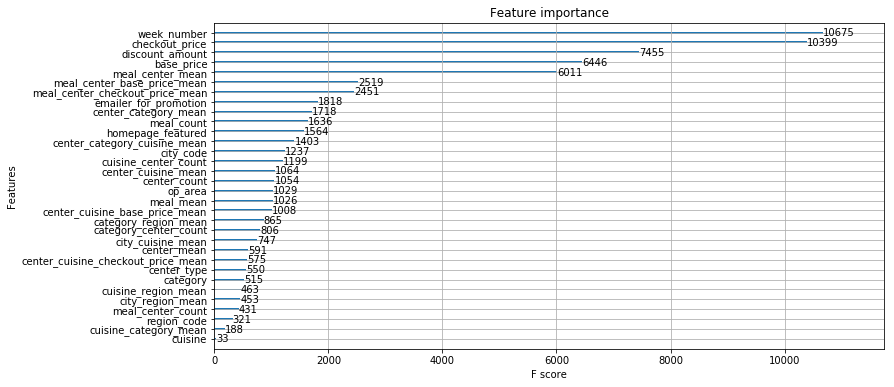

In [65]:
# Plot the importance of features.
_, ax = plt.subplots(1, 1, figsize = (12, 6))
plot_importance(xgb_model, ax)

In [69]:
# Model building light gbm.
lgbm_model = Model._train_lgb(X, y, 6, 4, 2500)

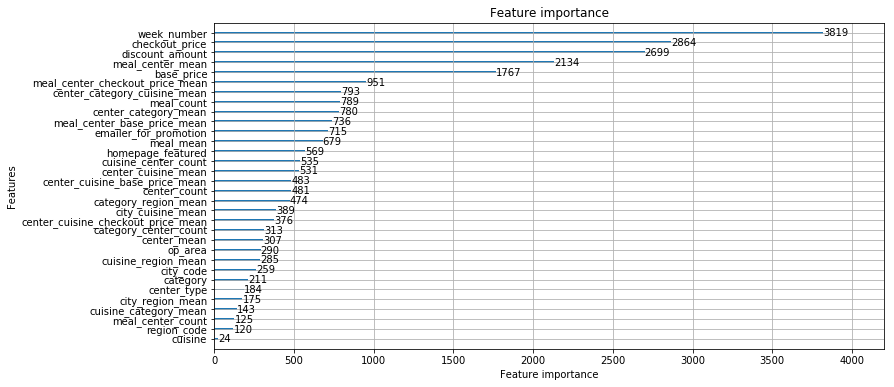

In [70]:
_, ax = plt.subplots(1, 1, figsize = (12, 6))
lgbm.plot_importance(lgbm_model, ax = ax)

In [72]:
# Let's make the predictions.
test.shape

(32573, 36)

In [73]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,week_number,city_code,...,center_mean,meal_mean,cuisine_region_mean,category_region_mean,city_cuisine_mean,city_region_mean,meal_center_base_price_mean,meal_center_checkout_price_mean,center_cuisine_base_price_mean,center_cuisine_checkout_price_mean
0,1028232,146,55,1885,158.11,159.11,0,0,42,647,...,163.475709,752.456365,333.230347,429.363987,279.324348,276.243387,145.808621,141.189034,215.949836,196.035152
1,1127204,146,55,1993,160.11,159.11,0,0,42,647,...,163.475709,598.853544,333.230347,429.363987,279.324348,276.243387,145.798828,141.732759,215.949836,196.035152
2,1212707,146,55,2539,157.14,159.14,0,0,42,647,...,163.475709,309.494594,333.230347,429.363987,279.324348,276.243387,146.142361,141.479097,215.949836,196.035152
3,1082698,146,55,2631,162.02,162.02,0,0,42,647,...,163.475709,104.239051,275.756380,429.363987,236.163220,276.243387,169.997597,145.123023,340.831065,320.688893
4,1400926,146,55,1248,163.93,163.93,0,0,42,647,...,163.475709,88.011872,275.756380,429.363987,236.163220,276.243387,171.336452,142.470887,340.831065,320.688893


In [75]:
# Using xgboost model to make predictions.
dtest = xgb.DMatrix(test.drop(['id', 'week', 'center_id', 'meal_id'], axis = 1))
pred_xgb_model = xgb_model.predict(dtest)

In [76]:
pred_xgb_model

array([141.32066, 128.5226 , 122.9132 , ..., 231.70197, 299.4441 ,
       129.05844], dtype=float32)

In [77]:
test_lgbm = test.drop(['id', 'week', 'center_id', 'meal_id'], axis = 1)
pred_lgbm_model = lgbm_model.predict(test_lgbm)

In [78]:
pred_lgbm_model

array([152.72746315, 137.57225552, 122.86293104, ..., 251.27997065,
       340.56114703, 147.66436893])

In [79]:
final_prediction = pd.read_csv('sample_submission.csv')

In [80]:
final_prediction.head()

,id,num_orders
0,1028232,0
1,1127204,0
2,1212707,0
3,1082698,0
4,1400926,0


In [81]:
final_prediction = final_prediction.copy()

In [82]:
# Let's use ensembling techniques.
final_prediction.num_orders = 0.7 * pred_xgb_model + pred_lgbm_model * 0.3
final_prediction.to_csv('final_prediction_ensemble.csv', index = False)
final_prediction.head()

,id,num_orders
0,1028232,144.742700
1,1127204,131.237497
2,1212707,122.898117
3,1082698,40.126312
4,1400926,29.902911
